В этом домашнем задании мы будем работь с набором данных, содержащим цены на дома в городе Эймс штата Айова.    
Данные можно найти в `data/ames_house_prices/`. Описание данных - в `data/ames_house_prices/data_description.txt`. Прочитайте описание переменных перед выполнением задания.   
Данные взяты с [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на Kaggle.

C этими данными мы уже работали, тогда мы делали EDA. Теперь мы будем заполнять отсутствующие значния и строить модели.

Размещаем импорты вверху.

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.impute import SimpleImputer
from impyute.imputation.cs import mice

pd.options.mode.chained_assignment = None
%matplotlib inline

0.Загрузите в переменную df данные из ames_house_prices/train.csv.

In [2]:
PATH = Path('../data/')
df = pd.read_csv(PATH / 'ames_house_prices/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


1.С помощью pandas выведите все колонки с отсутствующими значениями, необходимо вывести сколько отсутствующих значений, какой это процент от данных, и какой тип имеет эта колонка. Информация должна быть в одном dataframe, который содержит колонки dtype, n_missing, percentage_missing, а индексом выступает название колонки. Отсортируйте набор данных по убыванию значений percentage_missing и выведите на экран.

In [3]:
na_cols = df.columns[df.isna().any()]
na_df = pd.DataFrame(
    {
        'dtype' : df[na_cols].dtypes,
        'n_missing' : df[na_cols].isna().sum(),
        'percentage_missing' : df[na_cols].isna().sum()/len(df)
    }
)

na_df.sort_values(by='percentage_missing', ascending=False)

,dtype,n_missing,percentage_missing
PoolQC,object,1453,0.995205
MiscFeature,object,1406,0.963014
Alley,object,1369,0.937671
Fence,object,1179,0.807534
FireplaceQu,object,690,0.472603
LotFrontage,float64,259,0.177397
GarageType,object,81,0.055479
GarageYrBlt,float64,81,0.055479
GarageFinish,object,81,0.055479
GarageQual,object,81,0.055479


Сделайте вывод, какие колонки стоит удалить, а в каких мы сможем заполнить отсутствующие значения?  
Обычно мы удаляем те колонки, которые имеют слишком много отсутствующих значений.  
Пока только напишите вывод о том, какие колонки стоит удалить, но не удаляйте.


In [17]:
#удаляем колонки с более, чем 25% от длины датафрейма пропущенными значениями (делаю для демонстрации, inplace не устанавливаю)
na_lim = len(df) * 0.25
cols_to_drop = na_df.query('n_missing > @na_lim').index.tolist()
df.drop(cols_to_drop, axis=1).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


2.В нашем наборе данных целевая переменная - это `SalePrice`. Выделите набор признаков Х и переменную содержащую целевые значения у. 

In [5]:
X = df[np.setdiff1d(df.columns, 'SalePrice')]
y = pd.DataFrame(df['SalePrice'])

3.В переменные num_cols, cat_cols сохраните названия колонок в наборе признаков, содержащих числовые и категориальные данные соответственно. Тут можно не делать детального анализа и трансформации переменных в зависимости от их значения в наборе данных. Суть данного ДЗ не в этом. Но если вы сделаете аккуратное преобразование типов - велика вероятность, что точности моделей у вас будут лучше.

In [52]:
#включаю сюда переменные качества, переменные времени (год строительства, год обновления, год и месяц продажи) не включаю
cols_to_categorical = ['Id','MSSubClass','OverallCond','OverallQual']
X[cols_to_categorical] = X[cols_to_categorical].astype('object')

num_cols = X.select_dtypes('number').columns.tolist()
cat_cols = X.select_dtypes('object').columns.tolist()

4.Разделите данные на трейн и тест. В тест отведите 20% данных. Данные необходимо при разделении перемешать. Зафиксируйте разделение указав random_seed.

In [7]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

5.Обучим модель catboost. В этой модели не надо кодоировать категориальные переменные.
5.1.Перед обучением необходимо заполнить отсутствующие значения в категориальных переменных значением строки "None". В таком случае catboost будет воспринимать отсутствующие значения как отдельную категорию.
Выполните это запонение для X_train и X_test.

In [8]:
X_train.fillna('None', inplace=True)
X_test.fillna('None', inplace=True)

5.2.Запустите обучение регрессионной модели Catboost. Инициируйте модель с параметрами по умолчанию. При обучении необходимо передать в fit метод набор тренировочных данных, тестовых и список категориальных переменных. Также поставьте vebose=200 и plot=True. 
Для передачи данных можно использовать catboost.Pool, а можно не использовать.

Обучение должно запуститься без ошибок на данном этапе, если вы всё сделали по инструкциям выше.

In [9]:
cb = CatBoostRegressor()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)
cb.fit(train_pool, eval_set=test_pool, verbose=200, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74706.0148723	test: 85037.2475015	best: 85037.2475015 (0)	total: 293ms	remaining: 4m 53s
200:	learn: 16226.3845628	test: 27018.9303201	best: 27018.9303201 (200)	total: 27.7s	remaining: 1m 50s
400:	learn: 11992.7501023	test: 26157.3891427	best: 26152.0198454 (399)	total: 56.2s	remaining: 1m 24s
600:	learn: 9717.2147664	test: 25882.6095877	best: 25880.3565163 (593)	total: 1m 24s	remaining: 56.4s
800:	learn: 8239.8058981	test: 25778.9990968	best: 25778.2840537 (799)	total: 1m 55s	remaining: 28.8s
999:	learn: 7127.8047573	test: 25674.9105426	best: 25664.3385526 (926)	total: 2m 25s	remaining: 0us

bestTest = 25664.33855
bestIteration = 926

Shrink model to first 927 iterations.


5.3.Выведите изменение лосса в модели для тренировочного и тестового набора данных также с помощью matplotlib. Это позволит сохранить график при перезакгрузке нотубука.  
Подсказка: пример был в лекции.

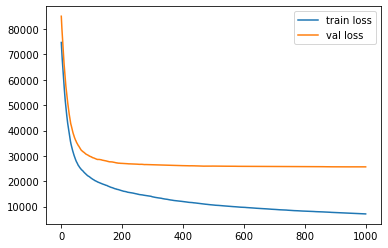

In [10]:
plt.plot(cb.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cb.get_evals_result()['validation']['RMSE'], label='val loss')
plt.legend()
plt.show()

5.4.Выведите лучшее значение ошибки модели на тренировочных и тестовых данных.

In [11]:
cb.get_best_score().keys()

dict_keys(['learn', 'validation'])

In [12]:
print('Train set RMSE: {}\nTest set RMSE: {}'.format(cb.get_best_score()['learn']['RMSE'], 
                                                      cb.get_best_score()['validation']['RMSE']))

Train set RMSE: 7127.804757277984
Test set RMSE: 25664.338552625577


5.5.Выведите топ 10 важных признаков для модели визуально в виде barplot, где столбцы расположены горизонтально.  
Подсказка: пример был в лекции.

In [13]:
def feature_importance_plot(model, dataset, n_features=None):
    lim_n_features = n_features or len(dataset.get_feature_names())
    sorted_feature_importance = model.feature_importances_.argsort()
    
    sorted_features = np.array(dataset.get_feature_names())[sorted_feature_importance]
    sorted_importances = model.feature_importances_[sorted_feature_importance]
    
    plt.figure(figsize=(14, 10))
    plt.barh(sorted_features[-lim_n_features:], sorted_importances[-lim_n_features:], color='lightgreen')
    plt.xlabel("CatBoost Feature Importance")
    
    plt.show()

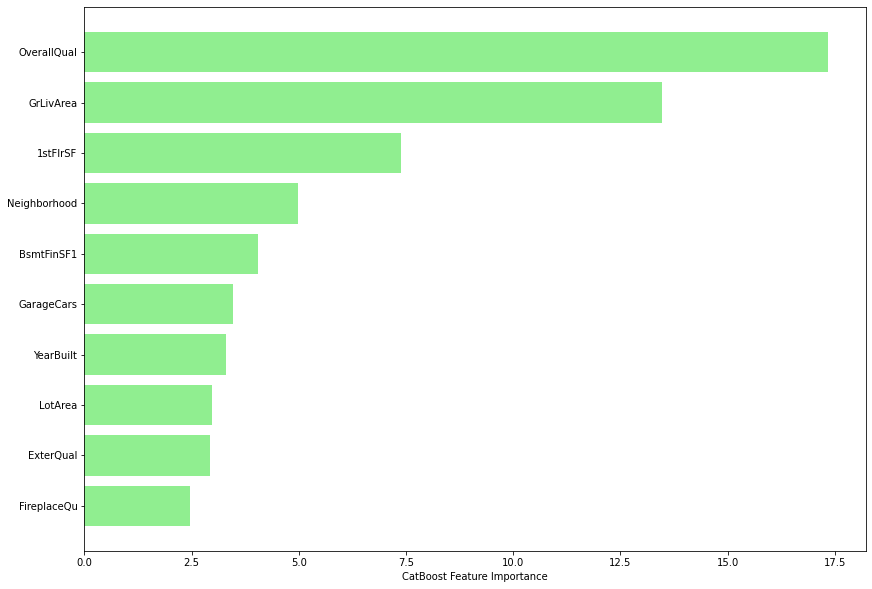

In [14]:
feature_importance_plot(cb, train_pool, n_features=10)

6.Теперь давайте заполним отсутствующие значения. Потом мы ещё раз натренируем CatBoost модель и сравним качество.

6.1.Удалите из df те колонки, которые вы ранее написали, что следует удалить. 
Результат запишите в новый датафрейм df_drop.

In [53]:
df_drop = df.drop(cols_to_drop, axis=1)

6.2.Выделите Х и у из df_drop, и разделите данные на train и test точно так же, как мы делали это выше. При разделении данных на train/test используйте те же настройки, что и ранее (процентовку теста и random_state).

In [54]:
X_drop = df_drop[np.setdiff1d(df_drop.columns, 'SalePrice')]
y_drop = df_drop.SalePrice

X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=test_size, 
                                                                        shuffle=True, random_state=42)

6.3.С помощью MICE заполните отсутствующие значения в числовых колонках X_train, X_test. После заполнения результат должен быть преобразован снова в dataframe с соответствующими названиями колонок.

In [55]:
#Adrop = after NaN-features were droped
num_cols_Adrop = X_drop_train.select_dtypes('number').columns.to_list()

mice_imputer_train = mice(X_drop_train[num_cols_Adrop].values)
mice_imputer_test = mice(X_drop_test[num_cols_Adrop].values)

In [56]:
imputed_num_train_df = pd.DataFrame(mice_imputer_train, columns=num_cols_Adrop)
imputed_num_test_df = pd.DataFrame(mice_imputer_test, columns=num_cols_Adrop)

7.Теперь заполните отсутствующие значения в категориальных колонках самым частотным по колонке. Используйте для этого SimpleImputer из Sklearn.
Тренируем метод на тренировочных данных, применяем к тренировочным и тестовым.

In [57]:
cat_cols_Adrop = X_drop_train.select_dtypes('object').columns.to_list()

simple_imputer_freq = SimpleImputer(strategy='most_frequent')
simple_imputer_freq.fit(X_drop_train[cat_cols_Adrop])

SimpleImputer(strategy='most_frequent')

In [58]:
imputed_cat_train_df = pd.DataFrame(simple_imputer_freq.transform(X_drop_train[cat_cols_Adrop]), columns=cat_cols_Adrop)
imputed_cat_test_df = pd.DataFrame(simple_imputer_freq.transform(X_drop_test[cat_cols_Adrop]), columns=cat_cols_Adrop)

In [59]:
#склеиваем обратно фреймы с численными и категориальными переменными
imputed_train_df = pd.concat([imputed_num_train_df, imputed_cat_train_df], axis=1)
imputed_test_df = pd.concat([imputed_num_test_df, imputed_cat_test_df], axis=1)

8.Запустите модель catboost, так же как и ранее, с параметрами по умолчанию, передав новые тренировочные и тестовые данные. 

Выведите графики уменьшения лосса на тестовых и трен. данных, стала ли модель обучаться лучше?  
Выведите метрику качества лучшей модели на трен. и тест. данных, как изменилась метрика?  
Выведите топ 10 самых важных признаков на графике. Изменился ли их набор?

In [60]:
cb_imputed = CatBoostRegressor()
imputed_train_pool = Pool(imputed_train_df, y_drop_train, cat_features=cat_cols_Adrop)
imputed_test_pool = Pool(imputed_test_df, y_drop_test, cat_features=cat_cols_Adrop)

cb_imputed.fit(imputed_train_pool, eval_set=imputed_test_pool, verbose=200, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74561.1091911	test: 84830.4002011	best: 84830.4002011 (0)	total: 126ms	remaining: 2m 6s
200:	learn: 16366.8078557	test: 27245.2976788	best: 27245.2976788 (200)	total: 25.4s	remaining: 1m 41s
400:	learn: 12079.0804146	test: 26528.1161477	best: 26517.3749060 (395)	total: 51.4s	remaining: 1m 16s
600:	learn: 9245.3523360	test: 26215.7067871	best: 26215.4099792 (599)	total: 1m 17s	remaining: 51.2s
800:	learn: 7469.0824917	test: 26107.6935462	best: 26095.2668123 (763)	total: 1m 43s	remaining: 25.8s
999:	learn: 6282.6853171	test: 26085.1286502	best: 26081.0923460 (996)	total: 2m 11s	remaining: 0us

bestTest = 26081.09235
bestIteration = 996

Shrink model to first 997 iterations.


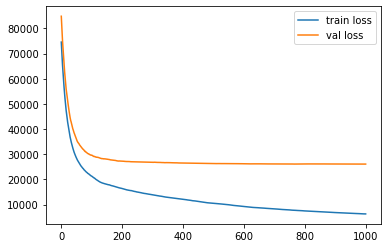

In [61]:
plt.plot(cb_imputed.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cb_imputed.get_evals_result()['validation']['RMSE'], label='val loss')
plt.legend()
plt.show()

In [62]:
print('Train set RMSE: {}\nTest set RMSE: {}'.format(cb_imputed.get_best_score()['learn']['RMSE'], 
                                                      cb_imputed.get_best_score()['validation']['RMSE']))

Train set RMSE: 6282.685317101127
Test set RMSE: 26081.092346037545


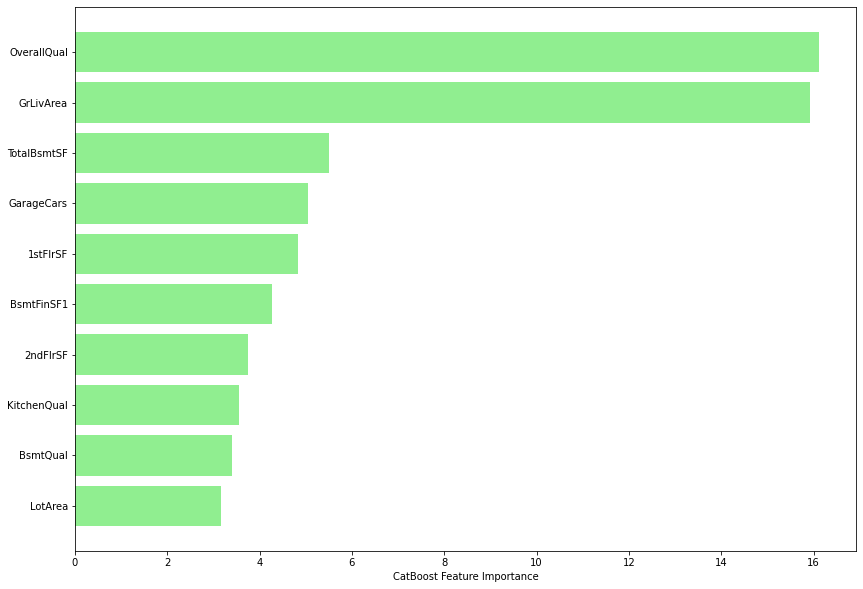

In [63]:
feature_importance_plot(cb_imputed, imputed_train_pool, n_features=10)

**Выводы:**  
- метрика качества для тренировочного набора улучшилась, а для тестового наоборот - ухудшилась (возможно, небольшое переобучение)  
- сильно изменилось распределение значимости признаков; интуитивно данные, полученные после алгоритмического заполнения пропущенных значений, хуже, чем после простого заполнения пропущенных значений строкой 'NoN'. Но, вероятно, стоило бы глубже изучить данные